**Fachprojekt Dokumentenanalyse** *WS 22/23* -- *Philipp Oberdiek, Gernot A. Fink* -- *Technische Universität Dortmund, Lehrstuhl XII, Mustererkennung in eingebetteten Systemen*
---
# Aufgabe 2: Bag-of-Words, Klassifikation

In dieser Aufgabe sollen unbekannte Dokumente zu bekannten Kategorien automatisch zugeordnet werden.

Die dabei erforderlichen numerischen Berechnungen lassen sich im Vergleich zu einer direkten Implementierung in Python erheblich einfacher mit NumPy / SciPy durchführen. Die folgende Aufgabe soll Ihnen die Unterschiede anhand eines kleinen Beispiels verdeutlichen.

Geben Sie für jede Katgorie des Brown Corpus die durchschnittliche Anzahl von Wörtern pro Dokument aus. Bestimmen Sie auch die Standardabweichung. Stellen Sie diese Statistik mit einem bar plot dar. Verwenden Sie dabei auch Fehlerbalken (siehe [`visualization.hbar_plot`](../common/visualization.py))

Berechnen Sie Mittelwert und Standardabweichung jeweils:

 - nur mit Python Funktionen
   hilfreiche Funktionen: `sum`, `float`, `math.sqrt`, `math.pow`

 - mit NumPy
   hilfreiche Funktionen: `np.array`, `np.mean`, `np.std`

http://docs.python.org/3/library/math.html  
http://docs.scipy.org/doc/numpy/reference/generated/numpy.mean.html  
http://docs.scipy.org/doc/numpy/reference/generated/numpy.std.html  

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import sys
from nltk.corpus import brown
from nltk.corpus import CategorizedCorpusReader


if ".." not in sys.path:
    sys.path.append("..")
    
from common.corpus import CorpusLoader

CorpusLoader.load()

In [3]:

brown : CategorizedCorpusReader = CorpusLoader.brown_corpus()
brown_categories = brown.categories()
brown_documents = brown.fileids()
brown_words = brown.words()

Solution with python stdlib

In [4]:
import math
# Implementieren Sie hier die beiden oben erwähnten Varianten
avg_num_words_per_category = []
std_per_category = []
for i in range(len(brown_categories)):
	category = brown_categories[i]
	documents = brown.fileids(categories=category)
	num_words_in_all_documents = 0

	for document in documents:
		num_words_in_all_documents += len(brown.words(fileids=document))

	# mean
	avg_num_words_per_category.append(num_words_in_all_documents / len(documents))
	mean = num_words_in_all_documents / len(documents)
	total_per_doc = 0
	for document in documents:
		num_words_in_doc = len(brown.words(fileids=document))
		total_per_doc += pow((num_words_in_doc - mean) ,2)
	std_per_category.append(math.sqrt(total_per_doc / len(documents)))

for i in range(len(brown_categories)):
	print(f"avg {brown_categories[i]}",avg_num_words_per_category[i] , "std" , std_per_category[i])
	

avg adventure 2391.103448275862 std 76.95244605356372
avg belles_lettres 2307.9466666666667 std 64.64691657165268
avg editorial 2281.6296296296296 std 48.053325431732716
avg fiction 2361.655172413793 std 71.55864528221204
avg government 2337.233333333333 std 98.64977896016234
avg hobbies 2287.3611111111113 std 57.44279897707795
avg humor 2410.5555555555557 std 96.29827633291967
avg learned 2273.6 std 66.50537572256846
avg lore 2297.8958333333335 std 59.24393062561111
avg mystery 2382.0416666666665 std 55.38236720493466
avg news 2285.318181818182 std 49.49920693913496
avg religion 2317.5882352941176 std 57.06555448473728
avg reviews 2394.3529411764707 std 74.93443500936675
avg romance 2414.551724137931 std 91.73484511008985
avg science_fiction 2411.6666666666665 std 46.87809249058194


Solution with numpy

In [5]:
import numpy as np 
# Implementieren Sie hier die beiden oben erwähnten Varianten
avg_num_words_per_category = []
std_per_category = []
for i in range(len(brown_categories)):
	category = brown_categories[i]
	documents = brown.fileids(categories=category)
	num_word_per_doc = [len(brown.words(fileids=document)) for document in documents]
	mean = np.mean(num_word_per_doc)
	std = np.std(num_word_per_doc) 
	print(f"avg {category} {mean}", f"std {std}")
	avg_num_words_per_category.append(mean)

avg adventure 2391.103448275862 std 76.95244605356373
avg belles_lettres 2307.9466666666667 std 64.64691657165268
avg editorial 2281.6296296296296 std 48.05332543173272
avg fiction 2361.655172413793 std 71.55864528221204
avg government 2337.233333333333 std 98.64977896016235
avg hobbies 2287.3611111111113 std 57.442798977077956
avg humor 2410.5555555555557 std 96.29827633291967
avg learned 2273.6 std 66.50537572256847
avg lore 2297.8958333333335 std 59.243930625611114
avg mystery 2382.0416666666665 std 55.38236720493467
avg news 2285.318181818182 std 49.49920693913495
avg religion 2317.5882352941176 std 57.065554484737284
avg reviews 2394.3529411764707 std 74.93443500936675
avg romance 2414.551724137931 std 91.73484511008986
avg science_fiction 2411.6666666666665 std 46.87809249058194


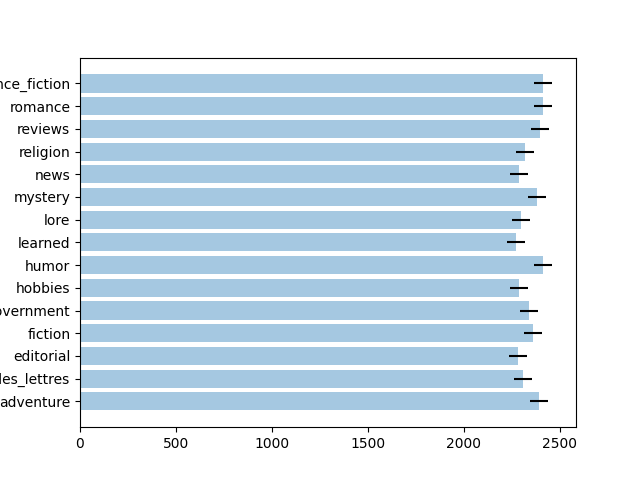

In [6]:
# visualize
from common.visualization import hbar_plot
hbar_plot(avg_num_words_per_category , brown_categories , std)

 ## Klassifikation von Dokumenten

Nachdem Sie sich nun mit der Struktur und den Eigenschaften des Brown Corpus vertraut gemacht haben, soll er die Datengrundlage für die Evaluierung von Algorithmen zur automatischen Klassifikation von Dokumenten bilden.
In der Regel bestehen diese Algorithmen aus drei Schritten:
 1. Vorverarbeitung
 2. Merkmalsberechnung
 3. Klassifikation

Bei der Anwendung auf Dokumente (Texte) werden diese Schritte wie folgt umgesetzt:

 - **Vorverarbeitung:** Filterung von stopwords und Abbildung von Wörtern auf Wortstämme.
 - **Merkmalsberechnung:** Jedes Dokument wird numerisch durch einen Vektor repräsentiert (--> NumPy), der möglichst die bzgl. der Klassifikation bedeutungsunterscheidenden Informationen enthählt.
 - **Klassifikation:** Jedem Merkmalsvektor (Dokument) wird ein Klassenindex (Kategorie) zugeordnet.

Details finden Sie zum Beispiel in:
http://www5.informatik.uni-erlangen.de/fileadmin/Persons/NiemannHeinrich/klassifikation-von-mustern/m00-www.pdf (section 1.3)

Eine sehr verbreitete Merkmalsrepräsentation für (textuelle) Dokumente sind sogenannte Bag-of-Words. Dabei wird jedes Dokument durch ein Histogram (Verteilung) über Wortfrequenzen repräsentiert. Man betrachtet dazu das Vorkommen von 'typischen' Wörtern, die durch ein Vokabular gegeben sind.

Bestimmen Sie ein Vokabular, also die typischen Wörter, für den Brown Corpus. Berechnen Sie dazu die 500 häufigsten Wörter (nach stemming und Filterung von stopwords und Satzzeichen).  
Bestimmen Sie außerdem das `category_wordlists_dict`, welches als Eingabe für `BagofWords.category_bow_dict` im Modul [features](../common/features.py) dient.

In [7]:
from common.features import BagOfWords, WordListNormalizer
stop_words = CorpusLoader.stopwords_corpus()
normalizer =  WordListNormalizer(stop_words)
words , stemmed_words  = normalizer.normalize_words(brown_words)

In [8]:
vocabulary = BagOfWords.most_freq_words(stemmed_words , 500)
category_wordlists_dict = {}
for category in brown_categories:
	category_wordlists_dict[category] = []
	docs = brown.fileids(categories=category)
	for doc in docs: 
		words  = brown.words(fileids=doc)
		category_wordlists_dict[category].append(words)


Berechnen Sie Bag-of-Words Repräsentationen für jedes Dokument des Brown Corpus. Verwenden Sie absolute Frequenzen. Speichern Sie die Bag-of-Word Repräsentationen für jede Kategorie in einem 2-D NumPy Array. Speichern Sie den Bag-of-Words Vektor für jedes Dokument in einer Zeile, so dass das Array (ndarray) folgende Dimension hat:

 |Dokument_kat| X |Vokabular|

|Dokument_kat| entspricht der Anzahl Dokumente einer Kategorie.
|Vokabular| entspricht der Anzahl Wörter im Vokabular (hier 500).

Eine einfache Zuordnung von Kategorie und Bag-of-Words Matrix ist durch ein Dictionary möglich.

Implementieren Sie die Funktion `BagOfWords.category_bow_dict` im Modul [features](../common/features.py).

In [9]:
print('Building Bag-of-Words feature vector representations...')
bow = BagOfWords(vocabulary)
category_bow_dict = bow.category_bow_dict(category_wordlists_dict)

Building Bag-of-Words feature vector representations...


Testen Sie ihre Implementierung mit folgendem Unittest:

In [10]:
import unittest

from utest.test_features import BagOfWordsTest

suite = unittest.TestSuite()
suite.addTest(BagOfWordsTest("test_category_bow_dict"))
runner = unittest.TextTestRunner()
runner.run(suite)

.
----------------------------------------------------------------------
Ran 1 test in 0.002s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

Um einen Klassifikator statistisch zu evaluieren, benötigt man eine Trainingsstichprobe und eine Teststichprobe der Daten die klassifiziert werden sollen. Die Trainingsstichprobe benötigt man zum Erstellen oder Trainieren des Klassifikators. Dabei werden in der Regel die Modellparameter des Klassifikators statistisch aus den Daten der Traingingsstichprobe geschätzt. Die Klassenzugehörigkeiten sind für die Beispiele aus der Trainingsstichprobe durch so genannte Klassenlabels gegeben.

Nachdem man den Klassifikator trainiert hat, interessiert man sich normalerweise dafür wie gut er sich unter realen Bedingung verhält. Das heißt, dass der Klassifikator bei der Klassifikation zuvor unbekannter Daten möglichst wenige Fehler machen soll. Dies simuliert man mit der Teststichprobe. Da auch für jedes Beispiel aus der Teststichprobe die Klassenzugehörigkeit bekannt ist, kann man am Ende die Klassifikationsergebnisse mit den wahren Klassenlabels (aus der Teststichprobe) vergleichen und eine Fehlerrate angeben.

In dem gegebenen Brown Corpus ist keine Aufteilung in Trainings- und Testdaten vorgegeben.

Wählen Sie daher die ersten 80% der Dokumente ÜBER ALLE KATEGORIEN als Trainingstichprobe und die letzten 20% der Dokumente ÜBER ALLE KATEGORIEN als Teststichprobe.

Erklären Sie, warum Sie die Stichproben über alle Kategorien zusammenstellen MÜSSEN.

**Antwort:**

Damit das Model beim Training die Dokumente von allen Kategorien sieht

Bitte beachten Sie, dass wir im Rahmen des Fachprojekts keinen Test auf unbekannten Testdaten simulieren. Wir haben ja bereits für die Erstellung der Vokabulars (häufigste Wörter, siehe oben) den kompletten Datensatz verwendet. Stattdessen betrachten wir hier ein sogenanntes Validierungsszenario, in dem wir die Klassifikationsleistung auf dem Brown Corpus optimieren. Die Ergebnisse lassen sich somit nur sehr bedingt auf unbekannte Daten übertragen.

Erstellen Sie nun die NumPy Arrays `train_samples`, `train_labels`, `test_samples` und `test_labels`, sodass diese mit den `estimate` und `classify` Methoden der Klassen im [`classification`](../common/classification.py) Modul verwendet werden können. Teilen Sie die Daten wie oben angegeben zu 80% in Trainingsdaten und 20% in Testdaten auf.

Hinweis: Vollziehen Sie nach, wie die Klasse `CrossValidation` im [`evaluation`](../common/evaluation.py) Modul funktioniert. Wenn Sie möchten, können Sie die Klasse zur Aufteilung der Daten verwenden.

In [11]:
from common.evaluation import CrossValidation
cv = CrossValidation(category_bow_dict , 5)
train_samples , train_labels , test_samples , test_labels = cv.corpus_fold(2)


Klassifizieren Sie nun alle Dokumente der Teststichprobe nach dem Prinzip des k-nächste-Nachbarn Klassifikators. Dabei wird die Distanz zwischen dem Merkmalsvektor eines Testbeispiels und allen Merkmalsvektoren aus der Trainingstichprobe berechnet. Das Klassenlabel des Testbeispiels wird dann über einen Mehrheitsentscheid der Klassenlabels der k ähnlichsten Merkmalsvektoren aus der Trainingsstichprobe bestimmt.

http://www5.informatik.uni-erlangen.de/fileadmin/Persons/NiemannHeinrich/klassifikation-von-mustern/m00-www.pdf (Abschnitt 4.2.7)

Bestimmen Sie die Distanzen von Testdaten zu Trainingsdaten mit cdist:  
http://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html  
Bestimmen Sie die k-nächsten Nachbarn auf Grundlage der zuvor berechneten Distanzen mit argsort:  
http://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html  
Überlegen Sie, welche zuvor von Ihnen implementierte Funktion Sie wiederverwenden können, um den Mehrheitsentscheid umzusetzen.  

Implementieren Sie die Funktionen `estimate` und `classify` in der Klasse `KNNClassifier` im Modul [`classification`](../common/classification.py).

Verwenden Sie die Euklidische Distanz und betrachten Sie zunächst nur den nächsten Nachbarn (k=1).

HINWEIS: Hier ist zunächst nur die Implementierung eines nächster Nachbar Klassifikators erforderlich. Diese soll aber in der nächsten Aufgabe zu einer Implementierung eines k-nächste Nachbarn Klassifikators erweitert werden. Berüchsichtigen Sie das in ihrer Implementierung.


In [21]:
from common.classification import KNNClassifier

knn_classifier = KNNClassifier(k_neighbors=1, metric='euclidean')
knn_classifier.estimate(train_samples, train_labels)
knn_test_labels = knn_classifier.classify(test_samples)
print(knn_test_labels)

[['romance']
 ['fiction']
 ['mystery']
 ['belles_lettres']
 ['humor']
 ['lore']
 ['science_fiction']
 ['editorial']
 ['belles_lettres']
 ['lore']
 ['news']
 ['learned']
 ['belles_lettres']
 ['belles_lettres']
 ['reviews']
 ['belles_lettres']
 ['reviews']
 ['lore']
 ['belles_lettres']
 ['learned']
 ['editorial']
 ['editorial']
 ['belles_lettres']
 ['humor']
 ['news']
 ['news']
 ['romance']
 ['fiction']
 ['mystery']
 ['romance']
 ['romance']
 ['science_fiction']
 ['belles_lettres']
 ['belles_lettres']
 ['editorial']
 ['government']
 ['government']
 ['learned']
 ['fiction']
 ['lore']
 ['lore']
 ['lore']
 ['reviews']
 ['learned']
 ['learned']
 ['science_fiction']
 ['news']
 ['learned']
 ['learned']
 ['editorial']
 ['learned']
 ['learned']
 ['news']
 ['news']
 ['hobbies']
 ['belles_lettres']
 ['learned']
 ['lore']
 ['lore']
 ['belles_lettres']
 ['reviews']
 ['learned']
 ['learned']
 ['belles_lettres']
 ['lore']
 ['hobbies']
 ['belles_lettres']
 ['editorial']
 ['learned']
 ['lore']
 ['lore']

Testen Sie ihre Implementierung mit folgendem Unittest:

In [22]:
import unittest
from utest.test_classification import ClassificationTest

suite = unittest.TestSuite()
suite.addTest(ClassificationTest("test_nn"))
runner = unittest.TextTestRunner()
runner.run(suite)

.

nn_test



----------------------------------------------------------------------
Ran 1 test in 0.002s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

Nachdem Sie mit dem `KNNClassifier` für jedes Testbeispiel ein Klassenlabel geschätzt haben, können Sie dieses mit dem tatsächlichen Klassenlabel vergleichen. Dieses können Sie wie bei den Traingingsdaten dem Corpus entnehmen.

Ermitteln Sie eine Gesamtfehlerrate und je eine Fehlerrate pro Kategorie. Implementieren Sie dazu die Klasse `ClassificationEvaluator` im [`evaluation`](../common/evaluation.py) Modul.

Warum ist diese Aufteilung der Daten in Training und Test problematisch? Was sagen die Ergebnisse aus?

**Antwort:**

In [26]:
from common.evaluation import ClassificationEvaluator

classification_eval = ClassificationEvaluator(knn_test_labels, test_labels)
err, n_wrong, n_sampels = classification_eval.error_rate()
category_error_rates = classification_eval.category_error_rates()
print('Classification error rates: ( n_wrong, n_samples ) error_rate')
print('\t{:15}: ( {:3} / {:3} ) {:6,.2f} %'.format('Overall', n_wrong, n_sampels, err))
print('Class specific :')
for category, error, n_wrong, n_samples in category_error_rates:
    print('\t{:15}: ( {:3} / {:3} ) {:6,.2f} %'.format(category, n_wrong, n_samples, error))

Classification error rates: ( n_wrong, n_samples ) error_rate
	Overall        : (  71 / 100 )  71.00 %
Class specific :
	adventure      : (   6 /   6 ) 100.00 %
	belles_lettres : (  10 /  15 )  66.67 %
	editorial      : (   4 /   5 )  80.00 %
	fiction        : (   5 /   6 )  83.33 %
	government     : (   4 /   6 )  66.67 %
	hobbies        : (   7 /   7 ) 100.00 %
	humor          : (   2 /   2 ) 100.00 %
	learned        : (   9 /  16 )  56.25 %
	lore           : (   7 /  10 )  70.00 %
	mystery        : (   3 /   5 )  60.00 %
	news           : (   5 /   9 )  55.56 %
	religion       : (   2 /   3 )  66.67 %
	reviews        : (   2 /   3 )  66.67 %
	romance        : (   4 /   6 )  66.67 %
	science_fiction: (   1 /   1 ) 100.00 %


Testen Sie ihre Implementierung mit folgendem Unittest:

In [15]:
import unittest

from utest.test_evaluation import ClassificationEvaluatorTest
unittest.main(ClassificationEvaluatorTest(), argv=[''], exit=False)

..
----------------------------------------------------------------------
Ran 2 tests in 0.001s

OK
